<a href="https://colab.research.google.com/github/alanmlewis/ProgrammingforChem/blob/main/Design_of_Experiment/Design_of_Experiment_Workshop_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Go to File > Save a copy in Drive

## PC Lab: Using Machine Learning for Design of Experiment

This workshop will cover:

- Design of Experiment: the general concept
- An introduction to Machine Learning using SciKit-Learn.

## Section A: Design of Experiment (DoE)

Often, chemists have relied upon prior knowledge and instincts to estimate which reagents and reaction conditions will get the best reaction result: this could be yield, cost efficiency, time efficiency, etc.

We also use "One Factor At a Time" techniques, where we change one factor while keeping all of the rest of the variables the same.

This works well in lots of cases, but there are many situations where there are so many combinations of variables that manually experimenting with each one is not a viable solution.

In DoE, multiple variables are screened all at once (i.e. we're changing loads of variables all at the same time). Statistical modelling based on these results can help us conclude about:

- How important one variable is compared to another
- Relationships between the variables themselves
- Relationships between the variables and our desired result (e.g. yield)
- Optimising the reaction process to get the best result.

The dataset we're using is taken from a paper studying a [palladium-catalysed cross-coupling reaction](https://www.science.org/doi/10.1126/science.aap9112).

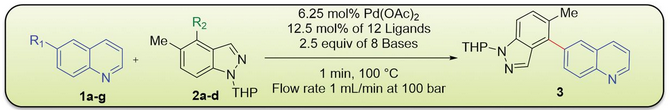

Perera et. al. wanted to optimise the reaction's yield. They varied the two reagents, the ligand and base used, and the	solvent of the reaction. Each of these categories had a few options, listed in the table below:

| Reactant 1 | Reactant 2 | Ligand| Base| Solvent |
| ----| ---- | ---- |----| ----|
|6-triflatequinoline | Trifluoroborate | P(Cy)3 | CsF | THF
|6-Bromoquinoline | Boronic Ester | dtbpf | KOH | MeCN
|6-Quinolineboronic acid pinacol ester | Bromide | P(o-Tol)3 | NaOH | MeOH
|6-Iodoquinoline | Boronic Acid | SPhos | NaHCO3 | DMF
|Potassium quinoline-6-trifluoroborate | | P(tBu)3 | LiOtBu
|6-quinoline-boronic acid hydrochloride | | P(Ph)3 | Et3N
| | | XPhos | K3PO4
| | | CataCXium A | No Base
| | | AmPhos
| | | No Ligand

 This makes a total of 7680 combinations. We have data on 2000 combinations, and later will see how few combinations we need to be able to get a good estimate of the yield.


There are a few ways to analyse the data from a DoE experiment, including using Python to build a multiple regression model ourselves, but today we're focussing on using a machine learning algorithm to build the model for us.

## Section B: What is Machine Learning?

In "classic" programming, the human user writes a program and feeds the computer an input that the computer uses to create an output.

In machine learning, the human user chooses an algorithm and some "hyperparameters" (we'll discuss them later), then the computer produces a model for us using the dataset it was provided. Then this model can make predictions about unseen data.

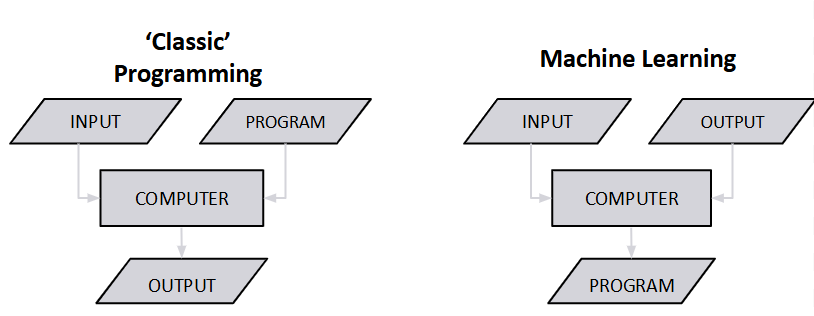

**Exercise 1**: The two cells below import the libraries and data we need for today's workshop. Run both cells, and have a look at the first 10 rows of features we will be using. You might want to Google some of the structures!

In [ ]:
#-----Importing libraries-------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [ ]:
#-----Importing data------------------------------------------------------------

features = pd.read_csv('https://raw.githubusercontent.com/alanmlewis/ProgrammingforChem/refs/heads/main/Design_of_Experiment/features.csv')
yields = pd.read_csv('https://raw.githubusercontent.com/alanmlewis/ProgrammingforChem/refs/heads/main/Design_of_Experiment/yields.csv').values.reshape(-1)

features.head(10)

,Reactant 1,Reactant 2,Ligand,Base,Solvent
0,6-triflatequinoline,Trifluoroborate,P(Cy)3,CsF,THF
1,6-triflatequinoline,Trifluoroborate,dtbpf,KOH,MeCN
2,6-Bromoquinoline,Boronic Ester,No Ligand,NaOH,THF
3,6-Quinolineboronic acid pinacol ester,Bromide,P(o-Tol)3,NaHCO3,MeOH
4,6-Iodoquinoline,Boronic Ester,SPhos,LiOtBu,DMF
5,6-Bromoquinoline,Boronic Ester,dtbpf,NaHCO3,THF
6,6-triflatequinoline,Boronic Acid,P(tBu)3,LiOtBu,MeOH
7,6-triflatequinoline,Boronic Acid,P(Cy)3,LiOtBu,THF
8,6-Bromoquinoline,Boronic Acid,P(Ph)3,NaHCO3,DMF
9,6-Quinolineboronic acid pinacol ester,Bromide,P(tBu)3,CsF,MeOH


The code below:
- Encodes the data so that the machine learning algorithm can interpret it
- Defines a machine learning model (chooses what type of model we'd like to build, we'll discuss this later too)
- Trains the model on the data we've provided
- Asks the model to predict some reaction yields from unseen conditions


**Exercise 2:** In this code, the model is predicting the yield for some unseen reaction conditions - these are not in the dataset the model learns from. See what it predicts! Then read through the code and try to understand what each section of code does.


**Exercise 3**: Try changing the solvent or the base (options are in the table above) in the array of unseen conditions. What gives the best predicted yield?

In [ ]:
#-----Unseen Conditions------------------------------------------------------

# Here we define the conditions under which we want to predict the yield

unseen_conditions = {
    'Reactant 1': ['6-Quinolineboronic acid pinacol ester'],
    'Reactant 2': ['Boronic Ester'],
    'Ligand': ['No Ligand'],
    'Base': ['KOH'],
    'Solvent': ['DMF']
}
unseen_values = pd.DataFrame(unseen_conditions)

#-----Encoding the dataset------------------------------------------------------

# To start with, the spreadsheet is in the wrong format for scikitlearn's tool to read the data.
# The "OneHotEncoder" turns our categories (e.g. solvent could be dioxane or THF, which are strings) into 1s and 0s.

encoder = OneHotEncoder(sparse_output=False)

# Transform the features into 1s and 0s
x = encoder.fit_transform(features)
y = yields
unseen_values = encoder.transform(unseen_values)

#-----Define the Machine Learning model-----------------------------------------

model = SVR()

#-----Fit the model and make a prediction-----------------------

model.fit(x, y)

#-----Make a prediction about the unseen conditions listed above
predicted_yield = model.predict(unseen_values)

print(predicted_yield)



[47.46882253]


The code above trains a model and makes a prediction about a single set of reaction conditions. But we have no idea if our model is any good, so we don't know whether to trust the prediction we just made!

To evaluate our model, we divide our data into two groups: training data and test data. We train the model using the training data, and then evaluate the model by predicting the yield of all of the reactions in the test set and compare it to the real yields.

**Exercise 4**: The code below returns an error as a RMSE ("root mean square error"), which measures how good the model's predictions of the yields of the test reactions is. Read through the code and make sure you understand what each section of code does.

What happens to the error when you remove or add variables from/into the dataset? Does leaving some information out lead to better predictions? (Hint: Each variable is the heading of a column in the "features" dataset. Find the line of code which allows you to choose what headings are included/excluded.)

In [ ]:
# Here, you can choose columns to exclude from the "features" (dataset full of input values) that'll be fed into the Machine Learning algorithm.
# Column headings include: 'Reactant 1','Reactant 2','Ligand','Base','Solvent'.
# The list is allowed to be empty.

excluded_headings = ['Solvent']

#-----Encoding the dataset-----,-------------------------------------------------

# To start with, the spreadsheet is in the wrong format for scikitlearn's tool to read the data.
# The "OneHotEncoder" turns our categories (e.g. solvent could be dioxane or THF, which are strings) into 1s and 0s.

encoder = OneHotEncoder(sparse_output=False)

# Transform the features
x = encoder.fit_transform(features.drop(excluded_headings, axis=1))
y = yields


#-----Define the Machine Learning model-----------------------------------------

model = SVR()

#-----Train the model and assess its' prediction accuracy-----------------------

# Split the full dataset into a training set and a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

# Fit the model
model.fit(x_train, y_train)

y_predict_test = model.predict(x_test)

# Test the accuracy of the model against the test set

RMSE = root_mean_squared_error(y_test, y_predict_test)
print(f'The root mean square error was {(RMSE)}%!')




The root mean square error was 18.90948424481962%!


## Section C: Learning Curves

Machine learning uses a given dataset to learn, and then makes predictions based off that learning. Hopefully, it should follow that a model produced from more data is able to make more accurate predictions.

To test this, we can produce a learning curve: a plot of a model's prediction accuracy against how many samples the model was trained on.

![lc.png](https://raw.githubusercontent.com/alanmlewis/ProgrammingforChem/refs/heads/main/Design_of_Experiment/lc.png)

This is produced by taking a "slice" of your training dataset and training the model on that, then doing the same on bigger and bigger "slices" with more and more samples.

**Exercise 1**: Edit the code below to add in a 'for' loop which each time you go through the loop:
- selects the first `n_train` features and yields
- trains a model on that subset of the data
- appends the %RMSE associated with that model onto a list

Finally, add a line to print the list of %RMSEs.

**Hint 1:** You saw `for` loops last year! If you don't remember how they work, try looking at the lists section of [this cheat sheet](https://github.com/ehmatthes/pcc_3e/releases/download/v1.0.0/beginners_python_cheat_sheet_pcc.pdf) (this also tells how to create and add things to a list. For more details on `for` loops have a look at [this online tutorial](https://www.w3schools.com/python/python_for_loops.asp).

**Hint 2:** If you're not sure how to select a subset of the data, find the line which tells us how many rows we currently use.

The root mean square error was 25.534400167346654%!
The root mean square error was 24.54152033417592%!
The root mean square error was 23.62273481363988%!
The root mean square error was 22.70968477573023%!
The root mean square error was 22.03484038314078%!
The root mean square error was 21.36687361788361%!
The root mean square error was 20.818423146997517%!
The root mean square error was 20.35659297515882%!
The root mean square error was 19.93367366987416%!
The root mean square error was 19.441862185015975%!
The root mean square error was 19.03367433662619%!
The root mean square error was 18.66237251410952%!
The root mean square error was 18.287233771126843%!
The root mean square error was 18.031871124724276%!
The root mean square error was 17.794911478256303%!
The root mean square error was 17.600607453449225%!
The root mean square error was 17.600607453449225%!
The root mean square error was 17.600607453449225%!
The root mean square error was 17.600607453449225%!


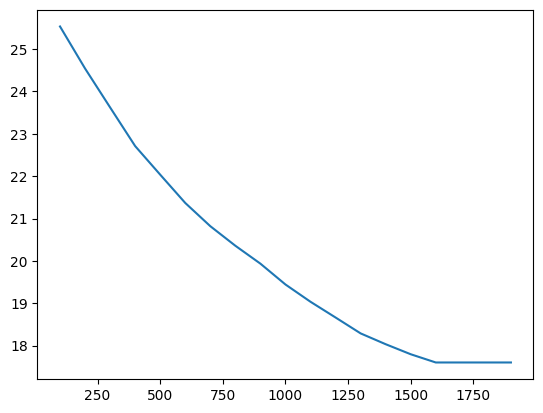

In [ ]:

#-----Encoding the dataset------------------------------------------------------

# To start with, the spreadsheet is in the wrong format for scikitlearn's tool to read the data.
# The "OneHotEncoder" turns our categories (e.g. solvent could be dioxane or THF, which are strings) into 1s and 0s.

encoder = OneHotEncoder(sparse_output=False)

# Transform the features
x = encoder.fit_transform(features)
y = yields
errors = []

#-----Define the Machine Learning model-----------------------------------------

model = SVR()

#-----Train the model and assess its' prediction accuracy-----------------------

# Split the full dataset into a training set and a test set
x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

for n_train in range(100,2000,100):

  x_train_truncated = x_train_full[:n_train]
  y_train_truncated = y_train_full[:n_train]

  # Fit the model
  model.fit(x_train_truncated, y_train_truncated)

  y_predict_test = model.predict(x_test)

  # Test the accuracy of the model against the test set
  rmse = root_mean_squared_error(y_test, y_predict_test)
  print(f'The root mean square error was {(rmse)}%!')

  errors.append(rmse)

plt.plot(range(100,2000,100), errors)
plt.show()


**Exercise 2**: Now add some code to the code block above which uses matplotlib to plot %RMSE against training sample size for each of your training sample sizes. What happens to the error as the number of samples increases? Can you make your graph look beautiful?

**Reminder:** the code `plt.plot(x,y)` will make you a line graph. Use `plt.show` to display the graph. Again, feel free to refer back to the [documentation](https://matplotlib.org/stable/tutorials/pyplot.html).

## Section D: What's actually happening when we press "go"?




We've seen that there's a "black box" which takes our data and builds a model. But what's actually happening?


Machine Learning for regression problems works as follows:

- A human (you!) chooses:
  - a learning algorithm, e.g. support vector regression
  - "hyperparameters" which define a loss function.

- The algorithm:
  - Chooses an initial guess for the parameters, e.g. m and c. These parameters define a model, but probably not a very good one.
  - Evaluates the "loss" of this model: A bigger loss value is a bigger punishment for the difference is between the model's predictions and the real life data.
  - Minimises the loss by changing the parameters and then evaluating the loss again and again, iteratively.
  - Outputs the optimised parameters. These define the "best" model within the limits your hyperparameters set out, i.e. with the smallest loss.

- The optimised model can be used to make predictions from unseen data.


## Section E: Hyperparameters

The machine learning algorithm completely depends on the **loss** calculated for each model.

The loss function contains **hyperparameters** which control the punishment for a model being inaccurate.

In support vector regression, the aim is to find a **hyperplane** (like a line or plane, but in many dimensions) which fits the datapoints as well as possible.

This is achieved by choosing two hyperparameters:
- **ε**: This is the how far away a point can be away from the hyperplane before punishment. Defines a **decision boundary** - a tube which we want to contain most of the datapoints. The further datapoints are outside the tube, the bigger the punishment.
- **C**: This is how big the punishment is for being outside the decision boundary.


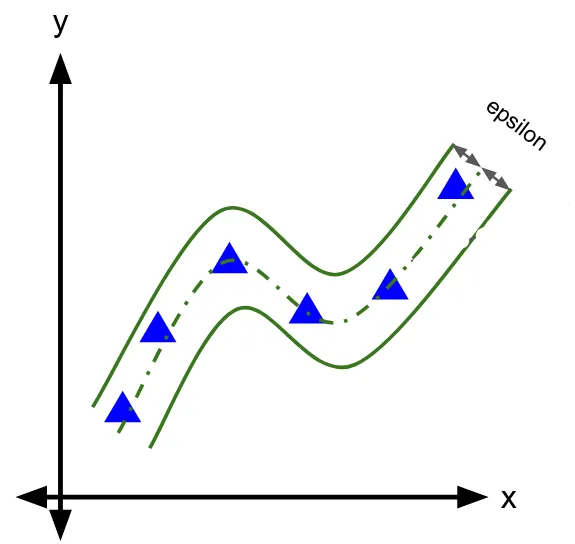

A big C and a small ε mean a small decision boundary and a large punishment for being outside it. This can lead to overfitting.

A small C and a big ε mean a large decision boundary and a small punishment for being outside it. This can lead to underfitting, i.e. a bad model.






**Exercise 1**: Try and change your hyperparameters so that your model is making predictions with the most error, and the least error. What's the highest and lowest you can get it?

**Hint:** Changing hyperparameters in small increments of 1 or 2 might not have a very big effect. Start by varying them by orders of magnitude.

**Challenge:** To do this efficiently, you could loop over a range of values of C, and then plot a graph of RMSE against C to find the optimum value. Then do the same for epsilon.

In [ ]:
#-----Encoding the dataset-----,-------------------------------------------------

# To start with, the spreadsheet is in the wrong format for scikitlearn's tool to read the data.
# The "OneHotEncoder" turns our categories (e.g. solvent could be dioxane or THF, which are strings) into 1s and 0s.

encoder = OneHotEncoder(sparse_output=False)

# Transform the features
x = encoder.fit_transform(features)
y = yields


#-----Define the Machine Learning model-----------------------------------------

model = SVR(C=95, epsilon=0.006)

#-----Train the model and assess its' prediction accuracy-----------------------

# Split the full datcaset into a training set and a test set
x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

# Fit the model
model.fit(x_train_full, y_train_full)

y_predict_test = model.predict(x_test)

# Test the accuracy of the model against the test set
accuracies = []
rmse = root_mean_squared_error(y_test, y_predict_test)
print(f'The root mean square error was {(rmse)}%!')

The root mean square error was 9.974152489265041%!


**Exercise 2**: Using your optimised hyperparameters, have a look at whether the new model has a different prediction of the yield for the unseen reaction conditions.

In [ ]:
unseen_conditions = {
    'Reactant 1': ['6-Quinolineboronic acid pinacol ester'],
    'Reactant 2': ['Boronic Ester'],
    'Ligand': ['No Ligand'],
    'Base': ['KOH'],
    'Solvent': ['DMF']
}

unseen_values = pd.DataFrame(unseen_conditions)


#-----Encoding the dataset------------------------------------------------------

# To start with, the spreadsheet is in the wrong format for scikitlearn's tool to read the data.
# The "OneHotEncoder" turns our categories (e.g. solvent could be dioxane or THF, which are strings) into 1s and 0s.

encoder = OneHotEncoder(sparse_output=False)

# Transform the features into 1s and 0s
x = encoder.fit_transform(features)
y = yields
unseen_values = encoder.transform(unseen_values)


#-----Define the Machine Learning model-----------------------------------------

model = SVR(C=95,epsilon=0.006)

#-----Fit the model and make a prediction-----------------------

model.fit(x, y)

#Pass encoded
predicted_yield = model.predict(unseen_values)

print(predicted_yield)



[33.71575257]


**Extension Exercise**: Many other machine learning algorithms exist for solving this type of regression problem. Using the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor), have a go at swapping Support Vector Regression with Random Forest Regression in the code cell for Exercise C.2. Can you get the error any lower? What does your learning curve now look like?


## Section F: Conclusions

You've got a new yield that's either really similar or wildly different. What conclusions can we draw from that about your model, how important your chosen hyperparameters are, or those reaction conditions?

In real life, we would be able to use this information to save lots of time and resources in the lab: "bad-looking" conditions can be dropped to low-priority to save effort, or "good-looking" conditions can be discovered.

You've seen that Machine Learning can be a really useful tool for reaction optimisation. What other uses for this type of regression model can you think of?

